# Map Processing Example
------------------

#### <font color="blue"> by: Jeremy Meinke (feel free to contact me here on GitHub, LinkedIn, or email)
------------------------------------------

This notebook will dive a bit more into how to process differently formatted maps, such as SPT and ACT.
It is a slight simplification of what has been conducted in our recent paper (ref to add).

The notebook is divided into two parts:
1.  Creating an SPT mask distance map - conveying distances (per pixel) to the nearest SPT mask pixel as used by Chown 2018.
2.  Steps to convert ACT maps into healpix format, with the option of subtracting a large-scale CMB Planck map (as done by our recent paper above).

---

In [1]:
from __future__ import division
import numpy as np
import pandas as pd
from astropy.table import Table
import healpy as hp
import matplotlib as mpl
import matplotlib.pyplot as plt
from pixell import enmap
from cycler import cycler
import time
import gc
###SPT maps are big... gc.collect() is a safety way to try to keep the notebook from using too much memory
import h5py

from stacking_code import stacking    ###My stacking code
from analysis_code import general     ###My general analysis code

###My personal matplotlib preferences
marker_cycle=["o","^","s","d","X","2","h","v",">"]
color_cycle=["k","b","r","c","orange","m","lime","grey","lavender"]
mpl.rcParams["axes.prop_cycle"] = cycler(color=color_cycle + color_cycle[::-1], marker=marker_cycle*2)

print("Last time run: %s"%time.asctime())

Last time run: Fri May 26 10:59:40 2023


**This next block will compile a set of .npy data files into a full HEALPix map of Nside=8192 for easy calling if you ever need to remove locations within a catalog if they are near one of these "holes" in the SPT-SZ map (see Chown et al. 2018 for details, they essentially cut a 5 arcmin hole around bright 150GHz pt sources and apodized the edges by a further 5 arcmin FWHM beam).**

*I have personally found that healpy either uses excessive amounts of memory or encounters a memory leak when reading/writing large HEALPix map files... so the block below will simply load the .npy files an combine them into an array of size (805306368,) just like a healpy map.  It can then be used for whatever catalog/need is required, all without saving the final map, since that caused memory problems for my (16GB) devices.*

**Feel free to comment out the block below when this is not needed**

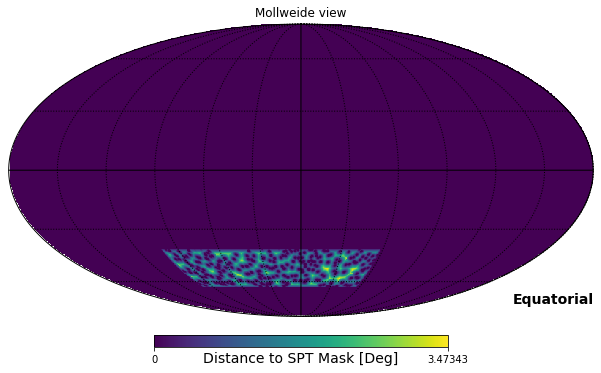

SPT-SZ Cluster Catalog Columns: 
 ['SPT_ID', 'RA', 'DEC', 'FIELD', 'XI', 'THETA_CORE', 'YSZ', 'DYSZ', 'REDSHIFT', 'REDSHIFT_UNC', 'REDSHIFT_LIMIT', 'XRAY', 'SPECZ', 'WEAK_LENSING', 'M500', 'M500_uerr', 'M500_lerr', 'M200', 'M200_uerr', 'M200_lerr', 'M500_marge', 'M500_marge_uerr', 'M500_marge_lerr', 'M200_marge', 'M200_marge_uerr', 'M200_marge_lerr']
--------------
Entire SPT-SZ Cluster Catalog (Bocquet et al. 2019) Size:  677
-------------- 

Number of SPT-SZ Clusters within a masked pixel (Chown 2018):  118
Number of SPT-SZ Clusters within 20 arcminutes of a masked pixel (Chown 2018):  206
-------------- 



In [3]:
## Comment this block out after first run through
## First time setup to generate the SPT-SZ mask distance map from smaller saved .npy files
divs = 20
spt_mask_distances = np.zeros(12*8192**2)  ## As the SPT HEALPix nside=8192
for d in range(divs):
    temp = np.load("./data/spt_mask_distances_map_subset%iof%i.npy"%(d+1, divs))
    ## Now assigning the distances in degrees (row 1) to their respective pixel index (row 0)
    spt_mask_distances[np.array(temp[0], dtype="int")] = temp[1]

## Test load and plot of the result
hp.mollview(spt_mask_distances, coord="C", unit="Distance to SPT Mask [Deg]")
hp.graticule()
plt.show()

## Example: Distances to nearest masked pixels for the SPT-SZ Cluster Catalog 
## (previously used in the stacking_example notebook)
catalog = Table.read("./data/2500d_cluster_sample_Bocquet19.fits", format="fits").to_pandas()
print("SPT-SZ Cluster Catalog Columns: \n", list(catalog.columns))
print("--------------")
print("Entire SPT-SZ Cluster Catalog (Bocquet et al. 2019) Size: ", len(catalog))
print("-------------- \n")
## Assign mask distances to each location (in degrees, and using interpolation)
catalog["SPT_mask_distance"] = hp.get_interp_val(spt_mask_distances, np.deg2rad(90-catalog["DEC"].values), np.deg2rad(catalog["RA"].values))

## See how many are within an SPT masked area:
print("Number of SPT-SZ Clusters within a masked pixel (Chown 2018): ", len(catalog[catalog["SPT_mask_distance"] == 0]))

## See how many are within 20 arcminutes of an SPT masked area:
print("Number of SPT-SZ Clusters within 20 arcminutes of a masked pixel (Chown 2018): ", len(catalog[catalog["SPT_mask_distance"] <= 20/60]))
## So not quite one third of the cluster catalog is within 20' of a masked pixel, 
## and thus may be influenced if stacked to that radius

## now to remove the mask_distance array from notebook memory just in case
spt_mask_distances = None; temp = None; del spt_mask_distances, temp
gc.collect()
print("-------------- \n")

## Map Processing Examples:
#### Processing SPT and ACT to be as similar as posible, while also subtracting the larger-scale Planck CMB (no-SZ) map
Showing how I took the SPT and ACT maps, used in the basic stacking_example notebook, and processed them primarily in spherical harmonic ell-space to both have the:
* Same spherical multipole ell cutoff of 10,000 (the max of SPT, ACT starts with a max ell of 30,000).
* Same map projection (HEALPix Nside=8192, while correcting for pixel window functions).
* Same map beam function/resolution of 2.10 arcmin (FWHM), corresponding to the lowest resolution map (ACT 90GHz).
* Subtraction of the SMICA Planck CMB (no-SZ) map, to act as a large-scale high-pass filter of the CMB.

*Final files are saved as alm spherical harmonic coefficients, to both take up less space and avoid the excessive memory of healpy read/write processes.*

#### First the SPT maps, since they are easier due to already being in HEALPix format: